# Information and Visualization of the Data

The data is from the researcher of the SunnyBrook Cardiac Data https://www.cardiacatlas.org/sunnybrook-cardiac-data/
I initially found the data at the Cardiac Atlas Project but saw that the data was organized in a very strange way. Manual contours (which was in a directory of its own seperate from patient mri image directories) for patient images were named different from the mri image that was in the patient data. After a lot of searching, I found that the researcher republished the data in a more  user friendly format on another website https://sourceforge.net/projects/cardiac-mr/files/. I changed the directories so that the manual contours are in the same directory as the mri images for a patient so that it is easier to  access and find images with their corresponding contour. 


In [1]:

import os
import pydicom
from skimage import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2



In [5]:
ds=pydicom.dcmread("Training_Data\\SC-HYP-38\\IM-0001-0218.dcm")
ds

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 204
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: MR Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.113619.2.234.90587033889.28551.1236098627613.446
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.528.1.1003.6.2
(0002, 0013) Implementation Version Name         SH: 'CMS_6.2'
(0002, 0016) Source Application Entity Title     AE: 'DICOMESSENGER'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'CARDIAC', 'NONE']
(0008, 0016) SOP Class UID                       UI: MR Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.840.113619.2.234.905870338

The dcm files contain a lot of data pertaining to the patient, who the image was made by, when it was made, and data about the image itself.

<function matplotlib.pyplot.show(close=None, block=None)>

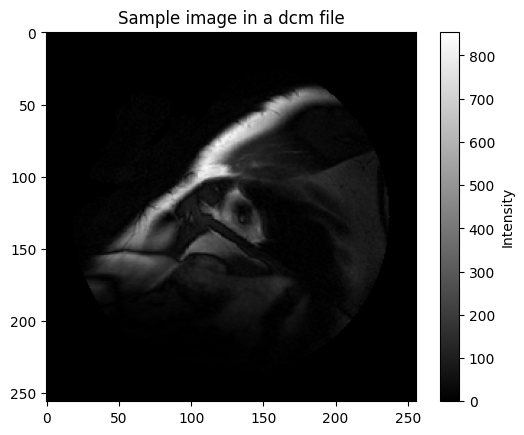

In [3]:
image = ds.pixel_array

plt.imshow(image, cmap='grey')
plt.title("Sample image in a dcm file")
plt.colorbar(label="Intensity")
plt.show

In [4]:
data = np.loadtxt("Training_Data\\SC-HYP-38\\IM-0001-0218-icontour-manual.txt")
print(data[:5])

[[138.5 132. ]
 [138.  132. ]
 [137.5 132. ]
 [137.  132. ]
 [136.5 132. ]]


<>:1: SyntaxWarning: invalid escape sequence '\S'
<>:1: SyntaxWarning: invalid escape sequence '\S'
C:\Users\Ashraf\AppData\Local\Temp\ipykernel_38572\2163793826.py:1: SyntaxWarning: invalid escape sequence '\S'
  data = np.loadtxt("Training_Data\SC-HYP-38\IM-0001-0218-icontour-manual.txt")


Here is an mri image and its corresponding countour map which contains coordinates on the image that are part of the left ventricle. 

The data is organized in a directory filled with subdirectories of a patient's mri image and (for some images) a manual contour of a slice of the cine (different from standard mri images in that it is meant for showing organs and tissue in a dynamic way) mri image.

In order to make a trained model, I need to make binary masks for the images that have a manual contour. Meaning that the images that have a manual contour will have an accompanying binary mask that a U-net model can then learn from and begin predicting on images without any manual contours.

# Making the Binary Masks for Training 

In [ ]:
root_dir = "Training_Data"

# Output directory for saving binary masks. Put it in the same directory as the training data
output_dir = "masks_training"

# List of contour types
contour_types = ["ocontour", "icontour", "p1contour", "p2contour"]

# Iterate over patient directories.
# I need to add an extra naming to the masks, 
# because some of the names would repeat just based off the "IM-XXXX-XXXX" and contour type.
# I decided to just append a number at the end of each image name which indicates what patient it was from.
a_number=1
for patient_dir in os.listdir(root_dir):
    patient_path = os.path.join(root_dir, patient_dir)
    if os.path.isdir(patient_path):
        # Iterate over DICOM files
        for dicom_file in os.listdir(patient_path):
            if dicom_file.endswith(".dcm"):
                # Load DICOM image
                dicom_image = io.imread(os.path.join(patient_path, dicom_file))

                # Extract DICOM ID
                dicom_id = dicom_file[:-4]  # Removes ".dcm" extension (use it to check for the manual contour)

                # Iterate over contour types
                for contour_type in contour_types:
                    # Check if corresponding contour file exists
                    contour_file = os.path.join(patient_path, f"{dicom_id}-{contour_type}-manual.txt")
                    if os.path.exists(contour_file):
                        # Load contour coordinates from file
                        contour_coords = np.loadtxt(contour_file)
                        # Arrays don't have half indices so I will lose the exact coordinates
                        x = np.round(contour_coords[:,0]).astype(int)
                        y = np.round(contour_coords[:,1]).astype(int)      
                        
                        # Create binary mask from contour coordinates
                        mask = np.zeros_like(dicom_image, dtype=np.uint8)
                        mask[x,y] = 1
                        
                        # to fill in the circle with 1s
                        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                        # Fill each detected contour
                        for contour in contours:
                            cv2.drawContours(mask, [contour], -1, color=1, thickness=cv2.FILLED)

                        # Save binary mask
                        mask_filename = os.path.join(output_dir, f"{dicom_id}_{contour_type}_{a_number}_mask.png")
                        io.imsave(mask_filename, mask)
    a_number+=1


In [7]:


# Load the PNG image
image = cv2.imread("masks_training\\IM-0001-0001_icontour_6_mask.png", cv2.IMREAD_GRAYSCALE)

# Print the array values
for row in image:
    print(row)
print(np.count_nonzero(image == 0),np.count_nonzero(image == 1))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

The program seems to have been a success. The binary masks were made for each mri image that has an associated manual contour image. However, there is a concern for class imbalance. Before filling the contour with cv2 that the data came with, there were only about 100-150 1s in the masks. However, after there are now about 2000 1s in every mask. This is still an issue that may likely pose a problem when training. I may have to address it with a specialized loss function or look into techniques to make the region of interest (the region in the mask with 1s) more pronounced. 

# Binary Masks for Validation Data

In [ ]:
# This is the same code that was used to create the binary masks for the training set.

root_dir = "Validation_Data"

# Output directory for saving binary masks. Put it in the same directory as the training data
output_dir = "masks_validation"

# List of contour types
contour_types = ["ocontour", "icontour", "p1contour", "p2contour"]

# Iterate over patient directories.
# I need to add an extra naming to the masks, 
# because some of the names would repeat just based off the "IM-XXXX-XXXX" and contour type.
# I decided to just append a number at the end of each image name which indicates what patient it was from.
a_number=1
for patient_dir in os.listdir(root_dir):
    patient_path = os.path.join(root_dir, patient_dir)
    if os.path.isdir(patient_path):
        # Iterate over DICOM files
        for dicom_file in os.listdir(patient_path):
            if dicom_file.endswith(".dcm"):
                # Load DICOM image
                dicom_image = io.imread(os.path.join(patient_path, dicom_file))

                # Extract DICOM ID
                dicom_id = dicom_file[:-4]  # Removes ".dcm" extension (use it to check for the manual contour)

                # Iterate over contour types
                for contour_type in contour_types:
                    # Check if corresponding contour file exists
                    contour_file = os.path.join(patient_path, f"{dicom_id}-{contour_type}-manual.txt")
                    if os.path.exists(contour_file):
                        # Load contour coordinates from file
                        contour_coords = np.loadtxt(contour_file)
                        # Arrays don't have half indices so I will lose the exact coordinates
                        x = np.round(contour_coords[:,0]).astype(int)
                        y = np.round(contour_coords[:,1]).astype(int)      
                        
                        # Create binary mask from contour coordinates
                        mask = np.zeros_like(dicom_image, dtype=np.uint8)
                        mask[x,y] = 1
                        
                        # to fill in the circle with 1s
                        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                        # Fill each detected contour
                        for contour in contours:
                            cv2.drawContours(mask, [contour], -1, color=1, thickness=cv2.FILLED)


                        # Save binary mask
                        mask_filename = os.path.join(output_dir, f"{dicom_id}_{contour_type}_{a_number}_mask.png")
                        io.imsave(mask_filename, mask)
    a_number+=1


# Binary Masks for Testing

In [ ]:
# This is the same code that was used to create the binary masks for the training set.

root_dir = "Testing_Data"

# Output directory for saving binary masks. Put it in the same directory as the training data
output_dir = "masks_testing"

# List of contour types
contour_types = ["ocontour", "icontour", "p1contour", "p2contour"]

# Iterate over patient directories.
# I need to add an extra naming to the masks, 
# because some of the names would repeat just based off the "IM-XXXX-XXXX" and contour type.
# I decided to just append a number at the end of each image name which indicates what patient it was from.
a_number=1
for patient_dir in os.listdir(root_dir):
    patient_path = os.path.join(root_dir, patient_dir)
    if os.path.isdir(patient_path):
        # Iterate over DICOM files
        for dicom_file in os.listdir(patient_path):
            if dicom_file.endswith(".dcm"):
                # Load DICOM image
                dicom_image = io.imread(os.path.join(patient_path, dicom_file))

                # Extract DICOM ID
                dicom_id = dicom_file[:-4]  # Removes ".dcm" extension (use it to check for the manual contour)

                # Iterate over contour types
                for contour_type in contour_types:
                    # Check if corresponding contour file exists
                    contour_file = os.path.join(patient_path, f"{dicom_id}-{contour_type}-manual.txt")
                    if os.path.exists(contour_file):
                        # Load contour coordinates from file
                        contour_coords = np.loadtxt(contour_file)
                        # Arrays don't have half indices so I will lose the exact coordinates
                        x = np.round(contour_coords[:,0]).astype(int)
                        y = np.round(contour_coords[:,1]).astype(int)      
                        
                        # Create binary mask from contour coordinates
                        mask = np.zeros_like(dicom_image, dtype=np.uint8)
                        mask[x,y] = 1
                        
                        # to fill in the circle with 1s
                        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                        # Fill each detected contour
                        for contour in contours:
                            cv2.drawContours(mask, [contour], -1, color=1, thickness=cv2.FILLED)


                        # Save binary mask
                        mask_filename = os.path.join(output_dir, f"{dicom_id}_{contour_type}_{a_number}_mask.png")
                        io.imsave(mask_filename, mask)
    a_number+=1


The following 2 images show a before and after of the binary masks. Before filling in the boundary for the contour, the contour was just a circle denoted by ones (object pixels) in 256 x 256 array filled with 0s (background pixels). This left the mask array with an extremely disproportionate amount of background pixels to object pixels. So I came back to this note boox and added a way to fill in the boundary for the contour. As one can clearly see, the filling was a success. 

There is still a very heavy imbalance of background pixels to object pixels in the masks, however. I may have to do some extra steps for preprocessing or change the way the model learns. But all of these steps to solve this imbalnce will be in the MyUnet notebook.

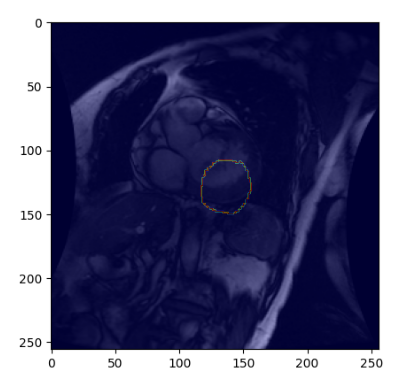

In [17]:
img = mpimg.imread('mriBeforeFill.png')
plt.axis('off')
plt.imshow(img)

64167 1369


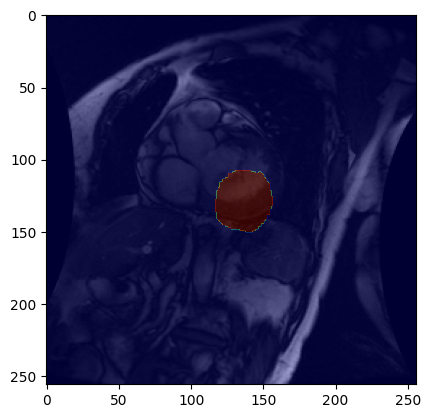

In [4]:
# Find contours in the mask. This function treats non-zero pixels as 1.
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


# Fill each detected contour
for contour in contours:
    cv2.drawContours(mask, [contour], -1, color=1, thickness=cv2.FILLED)

# 'filled' is now the mask
plt.imshow(image, cmap='gray')  # MRI images are often visualized in grayscale
plt.imshow(mask, cmap='jet', alpha= 0.4)
print(np.count_nonzero(mask == 0),np.count_nonzero(mask == 1))